Exploratory Data Analysis of Sample Dataset

In [49]:
sampling_rate = 1000
start_baseline_time = 0.0
end_baseline_time = 2.0
start_evoked_time = 2.0
end_evoked_time = 4.0

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
from scipy.signal import spectrogram, windows

from temporal_vit.data.data_audit import print_audit_report, audit_lfp_dataset
from temporal_vit.cloud.get_data import dataset_stats
from temporal_vit.data.preprocessing_core import process_trace_column


In [ ]:
dataset_stats_df = dataset_stats(bigquery.Client(project='neural-ds-fe73'))
sample_data = pd.read_parquet('../data/sample_data.parquet')
report = audit_lfp_dataset(sample_data)
print_audit_report(report, dataset_stats_df)

/opt/anaconda3/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [ ]:
sample_data['trace'] = process_trace_column(sample_data['trace'])

In [ ]:
FS = 1000
MIN_SECONDS = 5.0
min_len = int(FS * MIN_SECONDS)

trace_lengths = sample_data["trace"].apply(len)
short_mask = trace_lengths < min_len
n_short = int(short_mask.sum())
total = int(len(sample_data))
if total == 0:
    print("No rows to check.")
else:
    pct = 100.0 * n_short / total
    print(f"Short traces (<{min_len} samples): {n_short} / {total} ({pct:.2f}%)")


Trace plots

In [ ]:
# Configuration
FS = 1000  # Sampling frequency in Hz
STIMULUS_ONSET = 2.0  # Stimulus onset time in seconds
TRACE_LENGTH = 5001  # Expected trace length in samples

# Helper function to convert trace to numpy array
def parse_trace(trace):
    """Convert trace to numpy array, handling various formats."""
    if isinstance(trace, np.ndarray):
        return trace
    if isinstance(trace, list):
        return np.array(trace)
    if isinstance(trace, str):
        # Handle string representation of array
        return np.fromstring(trace.strip('[]'), sep=' ')
    return np.array(trace)

# Create time axis
time_axis = np.arange(TRACE_LENGTH) / FS  # Time in seconds


### 1. Raw Trace Plots: WT vs FMR1 Comparison
Compare example traces from each condition to visualize basic signal characteristics.


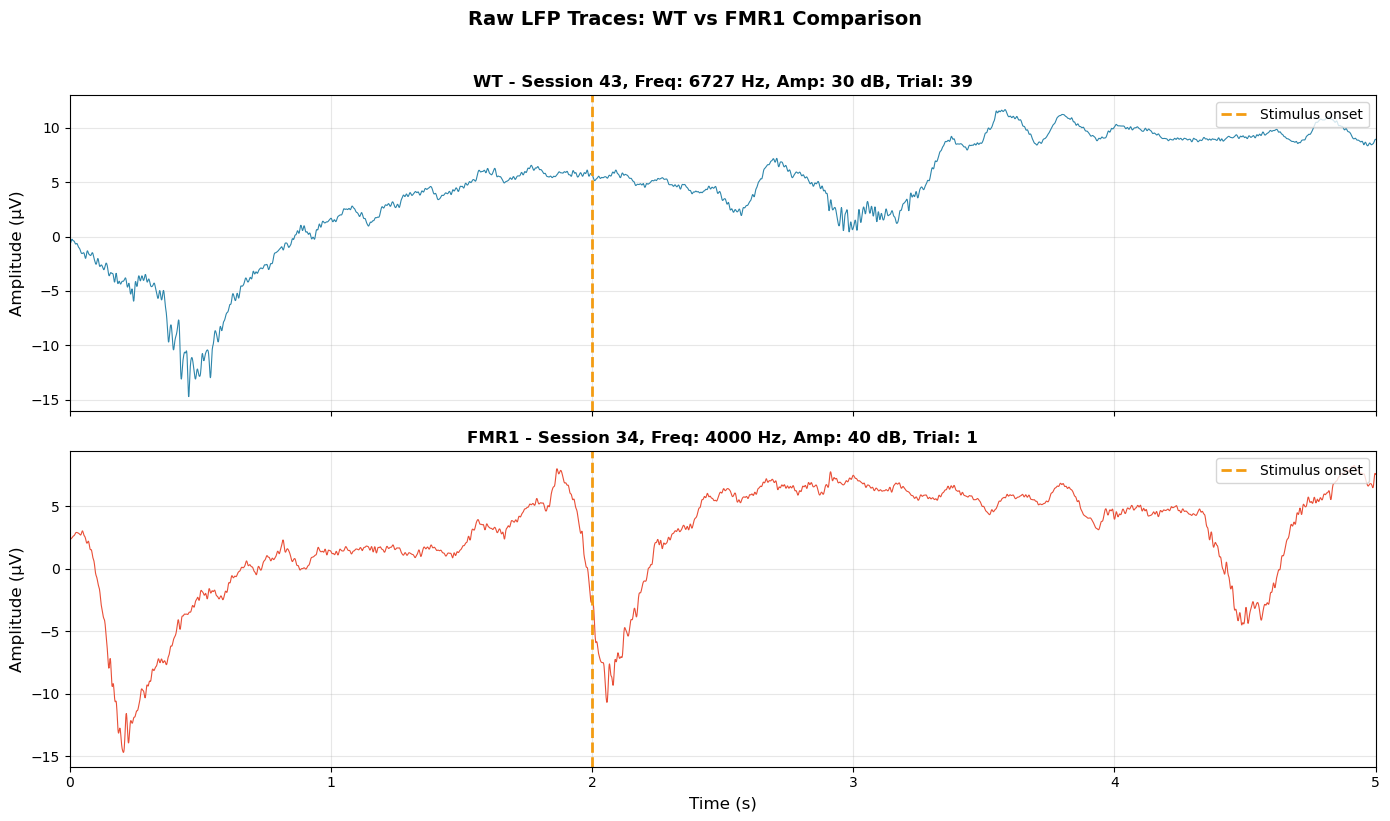

In [ ]:
# Raw Trace Plots: WT vs FMR1 Comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for idx, condition in enumerate(['WT', 'FMR1']):
    ax = axes[idx]
    
    # Get first trial from this condition
    condition_data = sample_data[sample_data['condition'] == condition].iloc[0]
    trace = parse_trace(condition_data['trace'])
    
    # Plot trace
    ax.plot(time_axis, trace, linewidth=0.8, color='#2E86AB' if condition == 'WT' else '#E94F37')
    
    # Add stimulus onset marker
    ax.axvline(STIMULUS_ONSET, color='#F39C12', linestyle='--', linewidth=2, label='Stimulus onset')
    
    # Styling
    ax.set_ylabel('Amplitude (μV)', fontsize=12)
    ax.set_title(f'{condition} - Session {condition_data["session"]}, '
                 f'Freq: {condition_data["frequency"]} Hz, Amp: {condition_data["amplitude"]} dB, '
                 f'Trial: {condition_data["trial_num"]}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 5])

axes[1].set_xlabel('Time (s)', fontsize=12)
plt.suptitle('Raw LFP Traces: WT vs FMR1 Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 1b. Linear Trend Check
Check for linear drift in traces by fitting a line to each trace and summarizing slopes by condition.


Computed linear trend slopes for 5895 traces.
FMR1: mean=9.006975e-03, std=8.953565e-01, median=-6.320668e-02, MAD=3.488044e-01, frac(|slope| > median+3*MAD)=0.190
WT: mean=1.122914e-01, std=1.338302e+00, median=1.955594e-02, MAD=6.931852e-01, frac(|slope| > median+3*MAD)=0.102


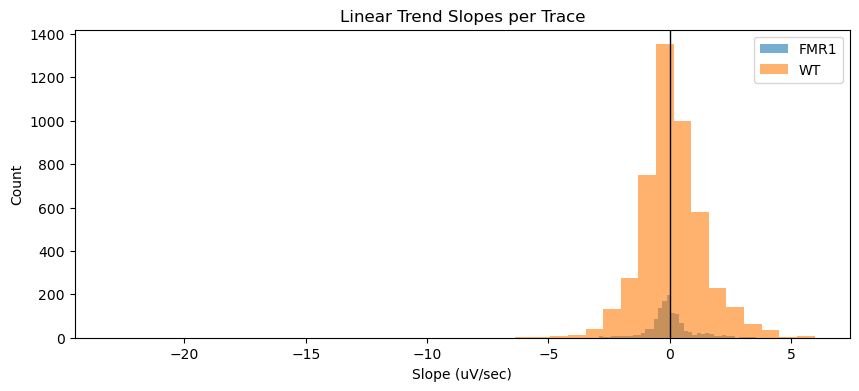

In [ ]:
# Linear trend check: per-trace slope using simple linear regression
TREND_START = 0.0
TREND_END = time_axis[-1]
trend_mask = (time_axis >= TREND_START) & (time_axis <= TREND_END)

def compute_linear_trend_slope(trace, time_axis, mask):
    if len(trace) != len(time_axis):
        return np.nan
    trace = np.asarray(trace, dtype=float)
    if not np.all(np.isfinite(trace)):
        return np.nan
    t = time_axis[mask]
    y = trace[mask]
    if t.size < 2:
        return np.nan
    coeffs = np.polyfit(t, y, 1)
    return coeffs[0]

trend_rows = []
for _, row in sample_data.iterrows():
    trace = parse_trace(row['trace'])
    slope = compute_linear_trend_slope(trace, time_axis, trend_mask)
    if np.isnan(slope):
        continue
    trend_rows.append({
        'condition': row['condition'],
        'session': row['session'],
        'trial_num': row['trial_num'],
        'slope': slope,
    })

trend_df = pd.DataFrame(trend_rows)
print(f"Computed linear trend slopes for {len(trend_df)} traces.")

def summarize_slopes(slopes):
    slopes = slopes.dropna().to_numpy()
    if slopes.size == 0:
        return None
    median = np.median(slopes)
    mad = np.median(np.abs(slopes - median))
    threshold = median + 3 * mad
    frac_high = np.mean(np.abs(slopes) > threshold) if mad != 0 else 0.0
    return median, mad, threshold, frac_high

for condition, group in trend_df.groupby('condition'):
    summary = summarize_slopes(group['slope'])
    if summary is None:
        continue
    median, mad, threshold, frac_high = summary
    print(
        f"{condition}: mean={group['slope'].mean():.6e}, std={group['slope'].std():.6e}, "
        f"median={median:.6e}, MAD={mad:.6e}, "
        f"frac(|slope| > median+3*MAD)={frac_high:.3f}"
    )

plt.figure(figsize=(10, 4))
for condition, group in trend_df.groupby('condition'):
    plt.hist(group['slope'], bins=40, alpha=0.6, label=condition)
plt.axvline(0, color='black', linewidth=1)
plt.title('Linear Trend Slopes per Trace')
plt.xlabel('Slope (uV/sec)')
plt.ylabel('Count')
plt.legend()
plt.show()


### 2. Overlay Plots: Trial-to-Trial Variability
Overlay multiple trials from the same session/stimulus to visualize within-session variability. This is key for understanding the hypothesis that FMR1 mice show higher trial-to-trial variability.


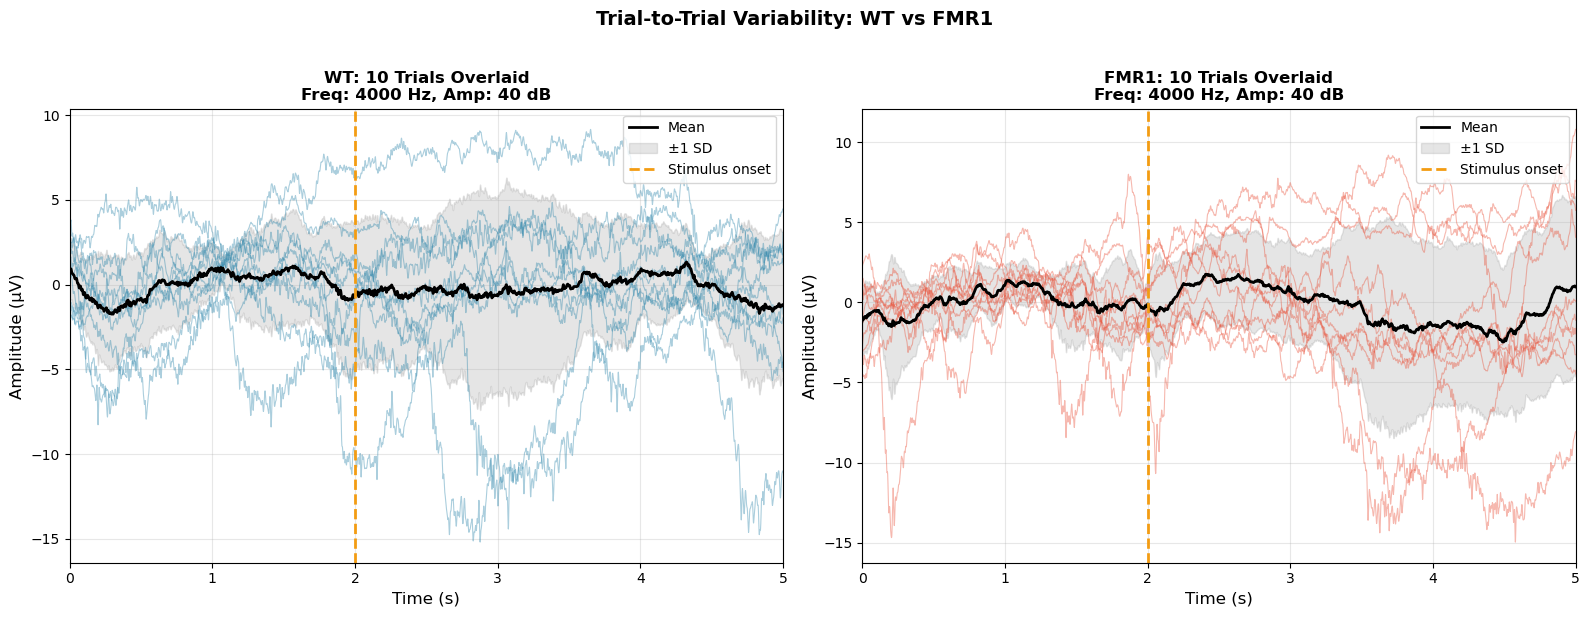


📊 Variability Statistics (Standard Deviation of Traces):
   WT: Mean SD across time = 3.5396
   FMR1: Mean SD across time = 3.3073


In [ ]:
# Overlay Plots: Multiple trials from same session/stimulus
N_TRIALS_OVERLAY = 10  # Number of trials to overlay

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = {'WT': '#2E86AB', 'FMR1': '#E94F37'}

for idx, condition in enumerate(['WT', 'FMR1']):
    ax = axes[idx]
    
    # Get data for this condition
    condition_df = sample_data[sample_data['condition'] == condition]
    
    # Pick a common frequency/amplitude combination with enough trials
    freq_amp_counts = condition_df.groupby(['frequency', 'amplitude']).size()
    best_combo = freq_amp_counts.idxmax()
    
    # Filter to this stimulus condition
    subset = condition_df[
        (condition_df['frequency'] == best_combo[0]) & 
        (condition_df['amplitude'] == best_combo[1])
    ].head(N_TRIALS_OVERLAY)
    
    # Plot each trial with transparency
    for i, (_, row) in enumerate(subset.iterrows()):
        trace = parse_trace(row['trace'])
        alpha = 0.3 + (0.5 * i / N_TRIALS_OVERLAY)  # Gradient alpha
        ax.plot(time_axis, trace, linewidth=0.8, alpha=0.4, color=colors[condition])
    
    # Calculate and plot mean trace
    all_traces = np.array([parse_trace(row['trace']) for _, row in subset.iterrows()])
    mean_trace = all_traces.mean(axis=0)
    std_trace = all_traces.std(axis=0)
    
    ax.plot(time_axis, mean_trace, linewidth=2, color='black', label='Mean')
    ax.fill_between(time_axis, mean_trace - std_trace, mean_trace + std_trace, 
                    alpha=0.2, color='gray', label='±1 SD')
    
    # Stimulus onset marker
    ax.axvline(STIMULUS_ONSET, color='#F39C12', linestyle='--', linewidth=2, label='Stimulus onset')
    
    # Styling
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Amplitude (μV)', fontsize=12)
    ax.set_title(f'{condition}: {N_TRIALS_OVERLAY} Trials Overlaid\n'
                 f'Freq: {best_combo[0]} Hz, Amp: {best_combo[1]} dB', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 5])

plt.suptitle('Trial-to-Trial Variability: WT vs FMR1', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print variability statistics
print("\n📊 Variability Statistics (Standard Deviation of Traces):")
for condition in ['WT', 'FMR1']:
    condition_df = sample_data[sample_data['condition'] == condition]
    freq_amp_counts = condition_df.groupby(['frequency', 'amplitude']).size()
    best_combo = freq_amp_counts.idxmax()
    subset = condition_df[
        (condition_df['frequency'] == best_combo[0]) & 
        (condition_df['amplitude'] == best_combo[1])
    ].head(N_TRIALS_OVERLAY)
    
    all_traces = np.array([parse_trace(row['trace']) for _, row in subset.iterrows()])
    mean_std = all_traces.std(axis=0).mean()
    print(f"   {condition}: Mean SD across time = {mean_std:.4f}")


### 3. Event-Aligned Plots: Stimulus-Locked Response
Focus on the evoked response window around stimulus onset. This visualization shows the neural response time-locked to stimulus presentation.


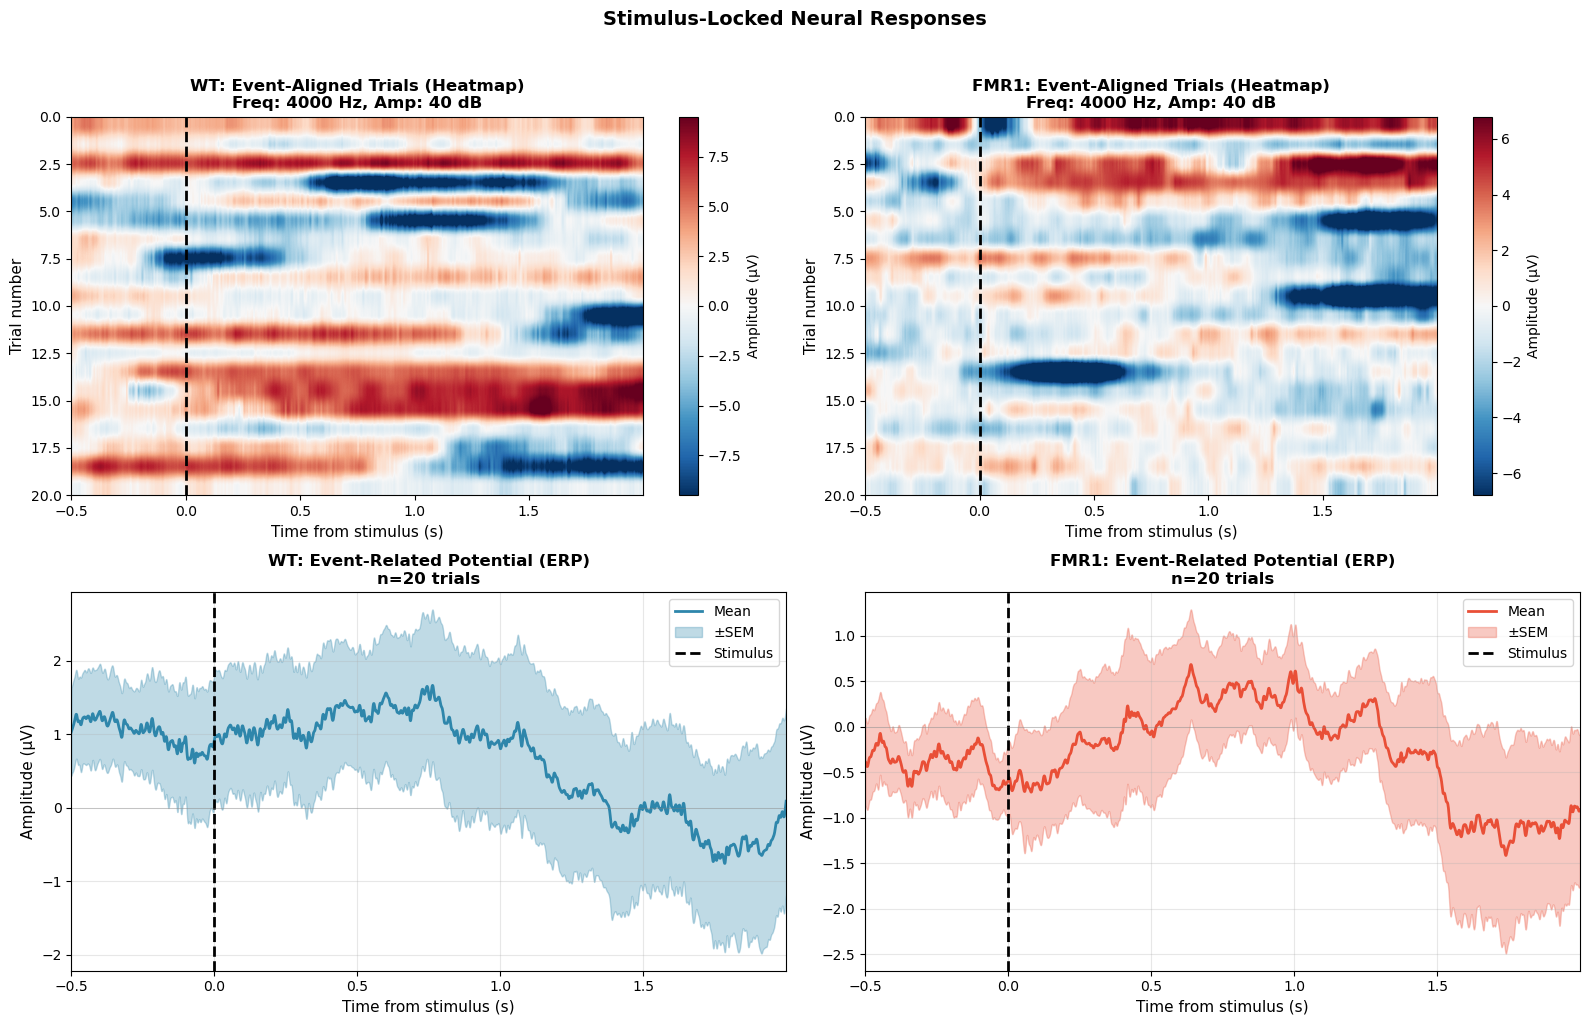

In [ ]:
# Event-Aligned Plots: Stimulus-Locked Response
# Focus on window around stimulus onset

# Define event-aligned window (relative to stimulus onset)
PRE_STIMULUS = 0.5   # seconds before stimulus
POST_STIMULUS = 2.0  # seconds after stimulus
N_TRIALS_EVENT = 20  # Number of trials for averaging

# Calculate sample indices for the window
onset_sample = int(STIMULUS_ONSET * FS)
pre_samples = int(PRE_STIMULUS * FS)
post_samples = int(POST_STIMULUS * FS)

# Event-aligned time axis (relative to stimulus onset)
event_time = np.arange(-pre_samples, post_samples) / FS

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for col, condition in enumerate(['WT', 'FMR1']):
    condition_df = sample_data[sample_data['condition'] == condition]
    
    # Get most common frequency/amplitude combo
    freq_amp_counts = condition_df.groupby(['frequency', 'amplitude']).size()
    best_combo = freq_amp_counts.idxmax()
    
    subset = condition_df[
        (condition_df['frequency'] == best_combo[0]) & 
        (condition_df['amplitude'] == best_combo[1])
    ].head(N_TRIALS_EVENT)
    
    # Extract event-aligned segments
    aligned_traces = []
    for _, row in subset.iterrows():
        trace = parse_trace(row['trace'])
        start_idx = onset_sample - pre_samples
        end_idx = onset_sample + post_samples
        if end_idx <= len(trace):
            aligned_traces.append(trace[start_idx:end_idx])
    
    aligned_traces = np.array(aligned_traces)
    mean_trace = aligned_traces.mean(axis=0)
    std_trace = aligned_traces.std(axis=0)
    sem_trace = std_trace / np.sqrt(len(aligned_traces))
    
    # Top row: Individual trials heatmap
    ax_heat = axes[0, col]
    im = ax_heat.imshow(aligned_traces, aspect='auto', cmap='RdBu_r',
                        extent=[event_time[0], event_time[-1], len(aligned_traces), 0],
                        vmin=-np.percentile(np.abs(aligned_traces), 95),
                        vmax=np.percentile(np.abs(aligned_traces), 95))
    ax_heat.axvline(0, color='black', linestyle='--', linewidth=2, label='Stimulus')
    ax_heat.set_xlabel('Time from stimulus (s)', fontsize=11)
    ax_heat.set_ylabel('Trial number', fontsize=11)
    ax_heat.set_title(f'{condition}: Event-Aligned Trials (Heatmap)\n'
                      f'Freq: {best_combo[0]} Hz, Amp: {best_combo[1]} dB', 
                      fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax_heat, label='Amplitude (μV)')
    
    # Bottom row: Mean ± SEM
    ax_mean = axes[1, col]
    color = '#2E86AB' if condition == 'WT' else '#E94F37'
    ax_mean.plot(event_time, mean_trace, linewidth=2, color=color, label='Mean')
    ax_mean.fill_between(event_time, mean_trace - sem_trace, mean_trace + sem_trace,
                         alpha=0.3, color=color, label='±SEM')
    ax_mean.axvline(0, color='black', linestyle='--', linewidth=2, label='Stimulus')
    ax_mean.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax_mean.set_xlabel('Time from stimulus (s)', fontsize=11)
    ax_mean.set_ylabel('Amplitude (μV)', fontsize=11)
    ax_mean.set_title(f'{condition}: Event-Related Potential (ERP)\n'
                      f'n={len(aligned_traces)} trials', fontsize=12, fontweight='bold')
    ax_mean.legend(loc='upper right')
    ax_mean.grid(True, alpha=0.3)
    ax_mean.set_xlim([event_time[0], event_time[-1]])

plt.suptitle('Stimulus-Locked Neural Responses', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


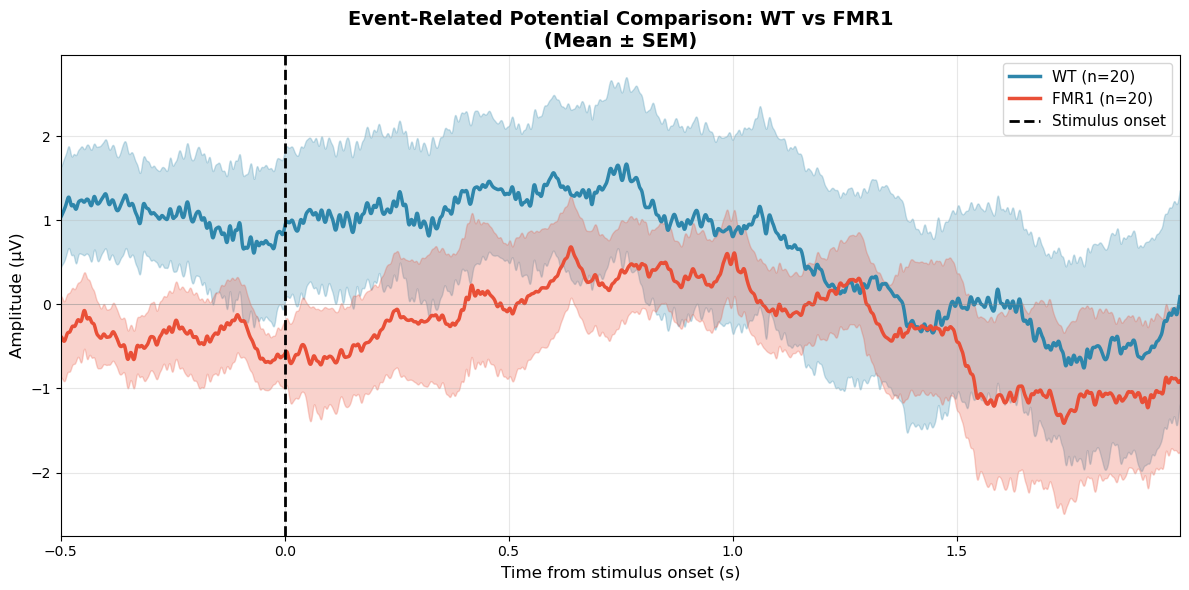


📊 ERP Summary Statistics:
--------------------------------------------------
WT:
   Stimulus: 4000 Hz @ 40 dB
   Peak amplitude (0-0.5s): 1.462 μV
   Peak latency: 457.0 ms
FMR1:
   Stimulus: 4000 Hz @ 40 dB
   Peak amplitude (0-0.5s): 0.719 μV
   Peak latency: 81.0 ms


In [ ]:
# Direct ERP Comparison: WT vs FMR1 Overlaid
fig, ax = plt.subplots(figsize=(12, 6))

erp_data = {}
for condition in ['WT', 'FMR1']:
    condition_df = sample_data[sample_data['condition'] == condition]
    
    # Get most common frequency/amplitude combo
    freq_amp_counts = condition_df.groupby(['frequency', 'amplitude']).size()
    best_combo = freq_amp_counts.idxmax()
    
    subset = condition_df[
        (condition_df['frequency'] == best_combo[0]) & 
        (condition_df['amplitude'] == best_combo[1])
    ].head(N_TRIALS_EVENT)
    
    # Extract event-aligned segments
    aligned_traces = []
    for _, row in subset.iterrows():
        trace = parse_trace(row['trace'])
        start_idx = onset_sample - pre_samples
        end_idx = onset_sample + post_samples
        if end_idx <= len(trace):
            aligned_traces.append(trace[start_idx:end_idx])
    
    aligned_traces = np.array(aligned_traces)
    mean_trace = aligned_traces.mean(axis=0)
    sem_trace = aligned_traces.std(axis=0) / np.sqrt(len(aligned_traces))
    
    erp_data[condition] = {
        'mean': mean_trace,
        'sem': sem_trace,
        'n': len(aligned_traces),
        'freq': best_combo[0],
        'amp': best_combo[1]
    }

# Plot both conditions
colors = {'WT': '#2E86AB', 'FMR1': '#E94F37'}
for condition, data in erp_data.items():
    ax.plot(event_time, data['mean'], linewidth=2.5, color=colors[condition], 
            label=f"{condition} (n={data['n']})")
    ax.fill_between(event_time, 
                    data['mean'] - data['sem'], 
                    data['mean'] + data['sem'],
                    alpha=0.25, color=colors[condition])

ax.axvline(0, color='black', linestyle='--', linewidth=2, label='Stimulus onset')
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.set_xlabel('Time from stimulus onset (s)', fontsize=12)
ax.set_ylabel('Amplitude (μV)', fontsize=12)
ax.set_title('Event-Related Potential Comparison: WT vs FMR1\n(Mean ± SEM)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([event_time[0], event_time[-1]])

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 ERP Summary Statistics:")
print("-" * 50)
for condition, data in erp_data.items():
    # Peak response in post-stimulus window (0 to 0.5s after stimulus)
    post_stim_mask = (event_time >= 0) & (event_time <= 0.5)
    peak_amplitude = np.max(np.abs(data['mean'][post_stim_mask]))
    peak_latency = event_time[post_stim_mask][np.argmax(np.abs(data['mean'][post_stim_mask]))]
    
    print(f"{condition}:")
    print(f"   Stimulus: {data['freq']} Hz @ {data['amp']} dB")
    print(f"   Peak amplitude (0-0.5s): {peak_amplitude:.3f} μV")
    print(f"   Peak latency: {peak_latency*1000:.1f} ms")


In [ ]:
len(sample_data["trace"][0])

5001

### Artifact Trial Count
Count trials flagged as artifacts using basic thresholds (non-finite values, length mismatch, and amplitude outliers).


In [ ]:
# Artifact Detection - Efficient Single-Pass Implementation
# =========================================================

# Tunable thresholds
EXPECTED_LEN = TRACE_LENGTH
MAX_ABS_THRESHOLD = None      # Set to float (e.g., 500.0) to enable absolute amplitude check
MAX_GRADIENT = None           # Set to float (e.g., 50.0) to enable gradient/spike detection
P2P_MAD_MULT = 5.0            # Peak-to-peak outlier: median + P2P_MAD_MULT * MAD

def compute_peak_to_peak(trace):
    """Compute peak-to-peak amplitude."""
    return float(np.max(trace) - np.min(trace))

def compute_max_gradient(trace):
    """Compute maximum absolute gradient (sudden jumps)."""
    return float(np.max(np.abs(np.diff(trace))))

# First pass: Basic checks + collect statistics for valid traces
artifact_rows = []
valid_traces_info = []  # Store (row_dict, trace, p2p, max_grad) for valid traces

print("Scanning traces for artifacts...")
for idx, row in sample_data.iterrows():
    trace = parse_trace(row['trace'])
    row_dict = row.to_dict()
    
    # Check 1: Empty trace
    if trace is None or len(trace) == 0:
        artifact_rows.append({**row_dict, 'reason': 'empty'})
        continue
    
    # Check 2: Length mismatch
    if EXPECTED_LEN is not None and len(trace) != EXPECTED_LEN:
        artifact_rows.append({**row_dict, 'reason': 'length_mismatch'})
        continue
    
    # Check 3: Non-finite values (NaN/Inf)
    if not np.all(np.isfinite(trace)):
        artifact_rows.append({**row_dict, 'reason': 'non_finite'})
        continue
    
    # Check 4: Absolute amplitude threshold (if enabled)
    if MAX_ABS_THRESHOLD is not None and np.max(np.abs(trace)) > MAX_ABS_THRESHOLD:
        artifact_rows.append({**row_dict, 'reason': 'max_abs_exceeded'})
        continue
    
    # Check 5: Gradient/spike detection (if enabled)
    max_grad = compute_max_gradient(trace)
    if MAX_GRADIENT is not None and max_grad > MAX_GRADIENT:
        artifact_rows.append({**row_dict, 'reason': 'gradient_spike'})
        continue
    
    # Trace passed basic checks - store for p2p outlier detection
    p2p = compute_peak_to_peak(trace)
    valid_traces_info.append((row_dict, p2p, max_grad))

# Calculate p2p threshold from valid traces using MAD
p2p_values = np.array([x[1] for x in valid_traces_info])
if p2p_values.size > 0:
    p2p_median = np.median(p2p_values)
    p2p_mad = np.median(np.abs(p2p_values - p2p_median))
    p2p_threshold = p2p_median + P2P_MAD_MULT * p2p_mad
else:
    p2p_median, p2p_mad, p2p_threshold = np.nan, np.nan, np.nan

# Second pass: Only check valid traces for p2p outliers
for row_dict, p2p, max_grad in valid_traces_info:
    if np.isfinite(p2p_threshold) and p2p > p2p_threshold:
        artifact_rows.append({**row_dict, 'reason': 'p2p_outlier'})

# Create artifact dataframe
artifact_df = pd.DataFrame(artifact_rows)
n_clean = len(sample_data) - len(artifact_df)

# Summary output
print("=" * 60)
print("ARTIFACT DETECTION SUMMARY")
print("=" * 60)
print(f"\n📊 Overall:")
print(f"   Total trials:    {len(sample_data)}")
print(f"   Clean trials:    {n_clean} ({100*n_clean/len(sample_data):.1f}%)")
print(f"   Artifact trials: {len(artifact_df)} ({100*len(artifact_df)/len(sample_data):.1f}%)")

print(f"\n📈 P2P Statistics (from {len(valid_traces_info)} valid traces):")
print(f"   Median: {p2p_median:.3f} μV")
print(f"   MAD:    {p2p_mad:.3f} μV")
print(f"   Threshold (median + {P2P_MAD_MULT}*MAD): {p2p_threshold:.3f} μV")

if not artifact_df.empty:
    print(f"\n🚨 Artifacts by Reason:")
    for reason, count in artifact_df['reason'].value_counts().items():
        print(f"   {reason}: {count} ({100*count/len(sample_data):.2f}%)")
    
    print(f"\n🔬 Artifacts by Condition:")
    for condition, count in artifact_df.groupby('condition').size().items():
        total_cond = len(sample_data[sample_data['condition'] == condition])
        print(f"   {condition}: {count}/{total_cond} ({100*count/total_cond:.2f}%)")
else:
    print("\n✅ No artifacts detected!")

print("=" * 60)


Scanning traces for artifacts...
ARTIFACT DETECTION SUMMARY

📊 Overall:
   Total trials:    5895
   Clean trials:    5891 (99.9%)
   Artifact trials: 4 (0.1%)

📈 P2P Statistics (from 5895 valid traces):
   Median: 15.141 μV
   MAD:    5.284 μV
   Threshold (median + 5.0*MAD): 41.560 μV

🚨 Artifacts by Reason:
   p2p_outlier: 4 (0.07%)

🔬 Artifacts by Condition:
   WT: 4/4635 (0.09%)


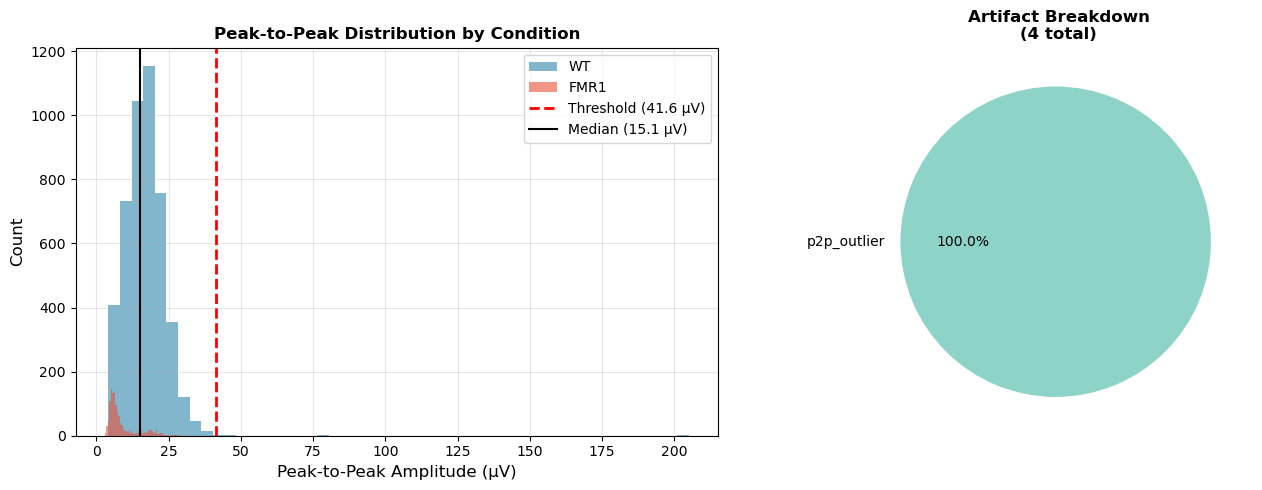

In [ ]:
# Visualize P2P distribution with threshold
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: P2P histogram by condition
ax1 = axes[0]
for condition in ['WT', 'FMR1']:
    condition_mask = sample_data['condition'] == condition
    condition_p2p = []
    for _, row in sample_data[condition_mask].iterrows():
        trace = parse_trace(row['trace'])
        if trace is not None and len(trace) > 0 and np.all(np.isfinite(trace)):
            condition_p2p.append(compute_peak_to_peak(trace))
    ax1.hist(condition_p2p, bins=50, alpha=0.6, label=condition, 
             color='#2E86AB' if condition == 'WT' else '#E94F37')

ax1.axvline(p2p_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Threshold ({p2p_threshold:.1f} μV)')
ax1.axvline(p2p_median, color='black', linestyle='-', linewidth=1.5,
            label=f'Median ({p2p_median:.1f} μV)')
ax1.set_xlabel('Peak-to-Peak Amplitude (μV)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Peak-to-Peak Distribution by Condition', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Artifact breakdown pie chart (if any artifacts)
ax2 = axes[1]
if not artifact_df.empty:
    reason_counts = artifact_df['reason'].value_counts()
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(reason_counts)))
    wedges, texts, autotexts = ax2.pie(reason_counts.values, labels=reason_counts.index, 
                                        autopct='%1.1f%%', colors=colors_pie,
                                        explode=[0.02]*len(reason_counts))
    ax2.set_title(f'Artifact Breakdown\n({len(artifact_df)} total)', fontsize=12, fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'No artifacts\ndetected! ✓', ha='center', va='center', 
             fontsize=16, fontweight='bold', color='green')
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    ax2.set_title('Artifact Breakdown', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## Spectrogram Analysis
Compute and visualize spectrograms from LFP traces. This is the input representation for the 3D ViT model.
 

In [ ]:

def compute_spectrogram(
    trace,
    fs=1000,
    nperseg=128,
    noverlap=120,
    freq_max=100,
    log_scale=True,
    normalize=False
):
    """
    Compute spectrogram from LFP trace.
    
    Args:
        trace: 1D numpy array of LFP samples
        fs: Sampling frequency (Hz)
        nperseg: Samples per FFT segment (frequency resolution = fs/nperseg)
        noverlap: Overlapping samples between segments
        freq_max: Maximum frequency to include (Hz)
        log_scale: Apply log10 transform (recommended for neural nets)
        normalize: Z-score normalize the spectrogram
        
    Returns:
        spec: 2D array (freq_bins, time_bins)
        freqs: Frequency axis
        times: Time axis
    """
    # Compute spectrogram
    window = windows.hann(nperseg)
    freqs, times, Sxx = spectrogram(
        trace,
        fs=fs,
        window=window,
        nperseg=nperseg,
        noverlap=noverlap,
        scaling='density'
    )
    
    # Crop to relevant frequency range (0 to freq_max Hz)
    freq_mask = freqs <= freq_max
    freqs = freqs[freq_mask]
    Sxx = Sxx[freq_mask, :]
    
    # Log transform (converts to dB-like scale)
    if log_scale:
        Sxx = np.log10(Sxx + 1e-10)  # Small epsilon to avoid log(0)
    
    # Z-score normalization (per spectrogram)
    if normalize:
        Sxx = (Sxx - Sxx.mean()) / (Sxx.std() + 1e-8)
    
    return Sxx, freqs, times

print("Spectrogram function defined.")
print(f"With nperseg=128, noverlap=120, freq_max=100:")
print(f"  Frequency resolution: {FS/128:.2f} Hz per bin")
print(f"  Expected freq bins: ~{int(100 / (FS/128)) + 1}")


Spectrogram function defined.
With nperseg=128, noverlap=120, freq_max=100:
  Frequency resolution: 7.81 Hz per bin
  Expected freq bins: ~13


### Single Trace Spectrogram Example
Visualize the spectrogram of a single LFP trace to verify the computation.


Input trace shape: (5001,)
Spectrogram shape: (13, 610) (freq_bins, time_bins)
Frequency range: 0.0 - 93.8 Hz
Time range: 0.064 - 4.936 s


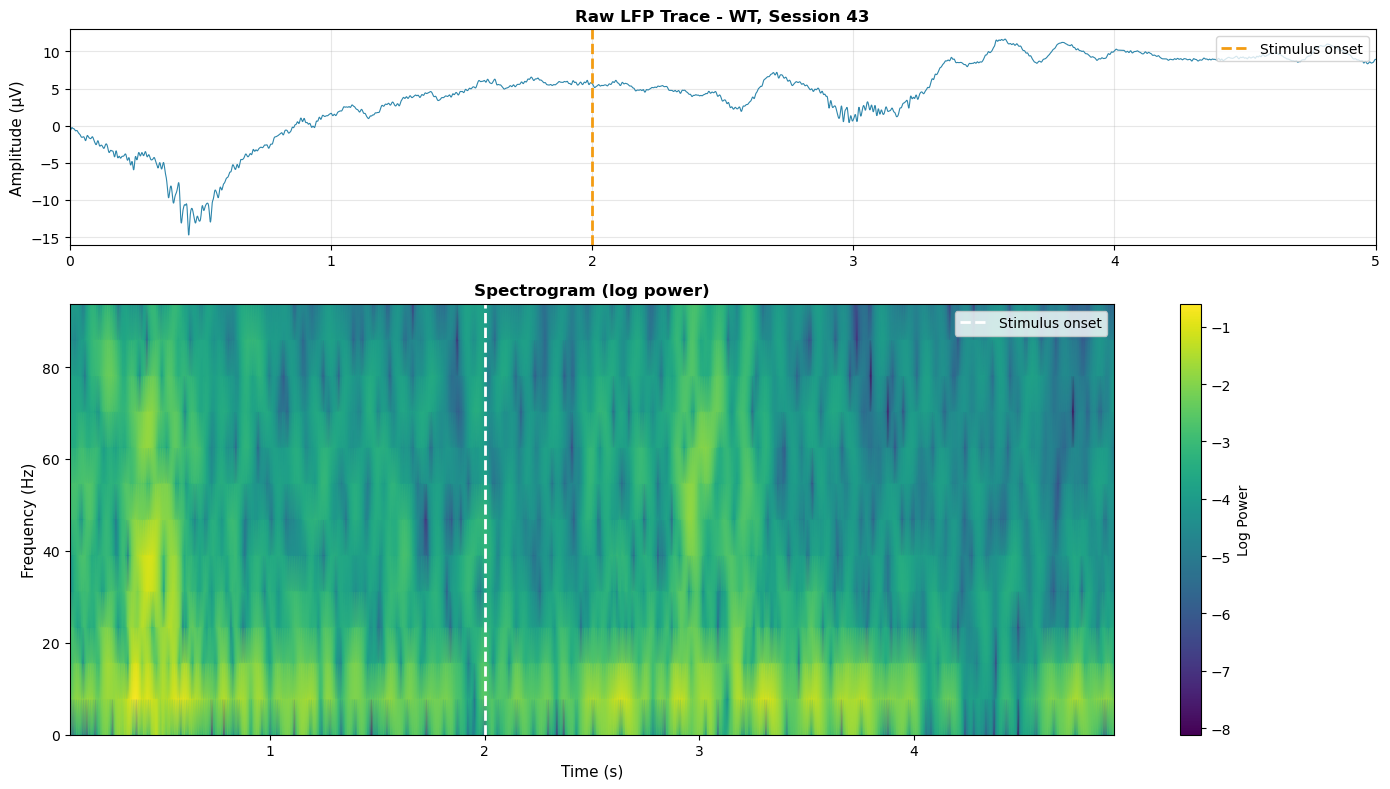

In [ ]:
# Single spectrogram example
example_row = sample_data.iloc[0]
trace = parse_trace(example_row['trace'])

# Compute spectrogram
spec, freqs, times = compute_spectrogram(trace, log_scale=True, normalize=False)

print(f"Input trace shape: {trace.shape}")
print(f"Spectrogram shape: {spec.shape} (freq_bins, time_bins)")
print(f"Frequency range: {freqs[0]:.1f} - {freqs[-1]:.1f} Hz")
print(f"Time range: {times[0]:.3f} - {times[-1]:.3f} s")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [1, 2]})

# Top: Raw trace
ax1 = axes[0]
trace_time = np.arange(len(trace)) / FS
ax1.plot(trace_time, trace, linewidth=0.8, color='#2E86AB')
ax1.axvline(STIMULUS_ONSET, color='#F39C12', linestyle='--', linewidth=2, label='Stimulus onset')
ax1.set_ylabel('Amplitude (μV)', fontsize=11)
ax1.set_title(f"Raw LFP Trace - {example_row['condition']}, Session {example_row['session']}", 
              fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 5])

# Bottom: Spectrogram
ax2 = axes[1]
im = ax2.pcolormesh(times, freqs, spec, shading='gouraud', cmap='viridis')
ax2.axvline(STIMULUS_ONSET, color='white', linestyle='--', linewidth=2, label='Stimulus onset')
ax2.set_xlabel('Time (s)', fontsize=11)
ax2.set_ylabel('Frequency (Hz)', fontsize=11)
ax2.set_title('Spectrogram (log power)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
plt.colorbar(im, ax=ax2, label='Log Power')

plt.tight_layout()
plt.show()


### Spectrogram Parameter Comparison
Compare different `nperseg` values to see the trade-off between time and frequency resolution.


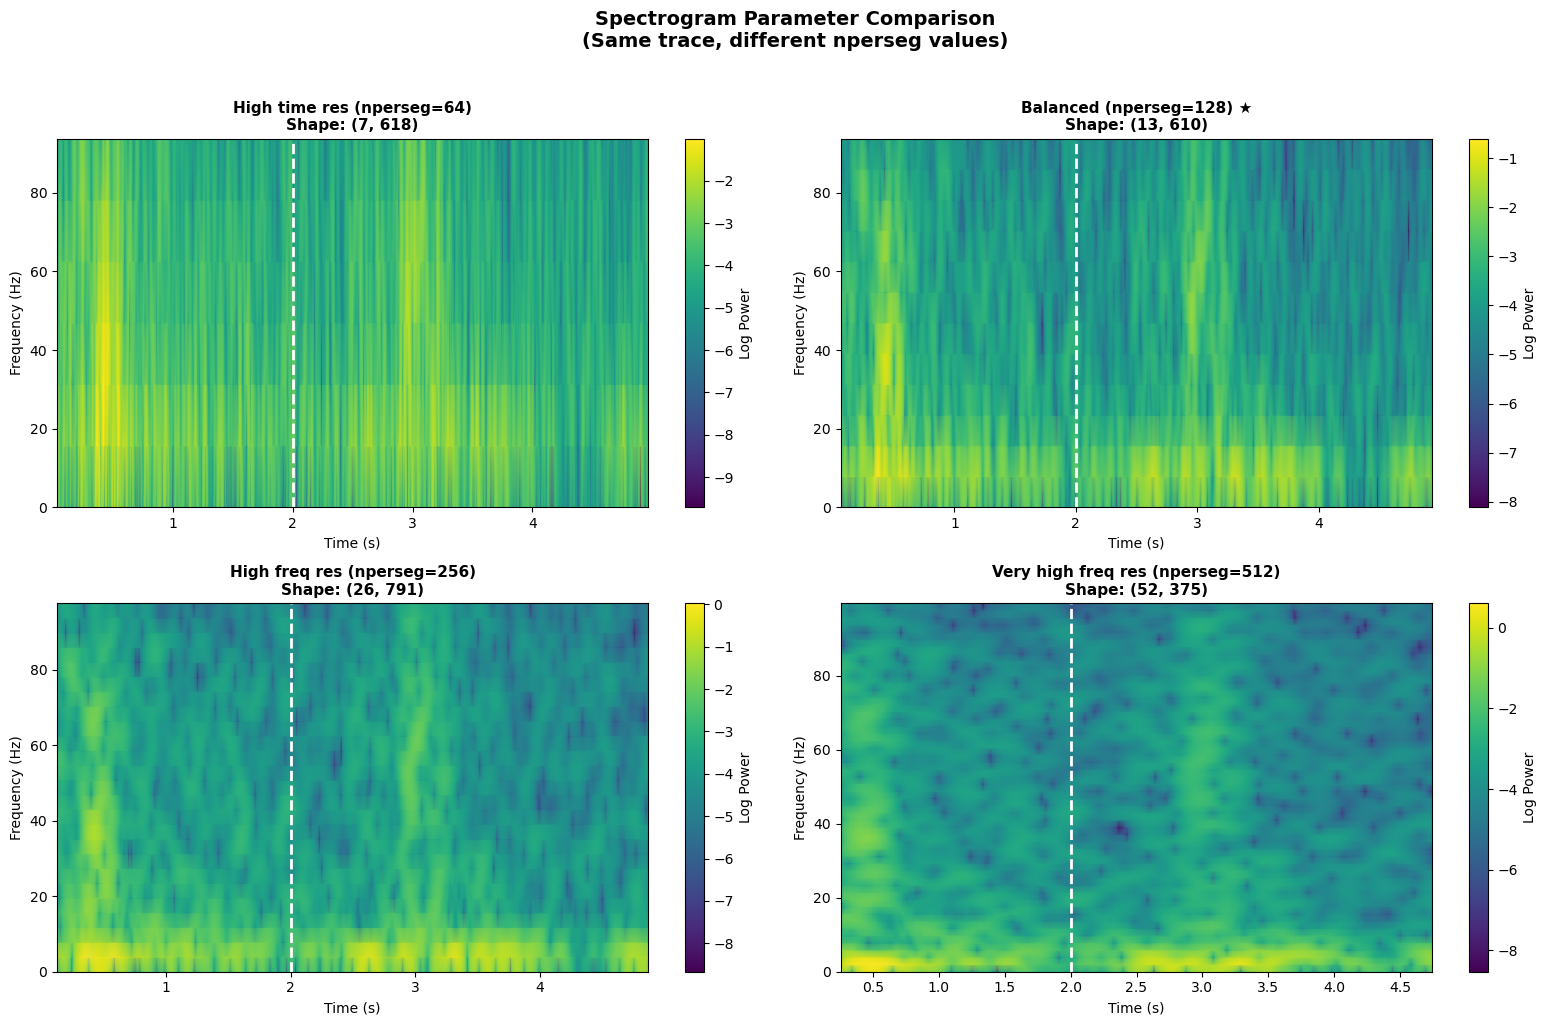


📊 Parameter Comparison Summary:
----------------------------------------------------------------------
Parameters                          Freq Bins    Time Bins    Shape          
----------------------------------------------------------------------
High time res (nperseg=64)          7            618          (7, 618)       
Balanced (nperseg=128) ★            13           610          (13, 610)      
High freq res (nperseg=256)         26           791          (26, 791)      
Very high freq res (nperseg=512)    52           375          (52, 375)      


In [ ]:
# Compare different spectrogram parameters
param_sets = [
    {'nperseg': 64,  'noverlap': 56,  'name': 'High time res (nperseg=64)'},
    {'nperseg': 128, 'noverlap': 120, 'name': 'Balanced (nperseg=128) ★'},
    {'nperseg': 256, 'noverlap': 250, 'name': 'High freq res (nperseg=256)'},
    {'nperseg': 512, 'noverlap': 500, 'name': 'Very high freq res (nperseg=512)'},
]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for ax, params in zip(axes, param_sets):
    spec, freqs, times = compute_spectrogram(
        trace, 
        nperseg=params['nperseg'], 
        noverlap=params['noverlap'],
        log_scale=True,
        normalize=False
    )
    
    im = ax.pcolormesh(times, freqs, spec, shading='gouraud', cmap='viridis')
    ax.axvline(STIMULUS_ONSET, color='white', linestyle='--', linewidth=2)
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_ylabel('Frequency (Hz)', fontsize=10)
    ax.set_title(f"{params['name']}\nShape: {spec.shape}", fontsize=11, fontweight='bold')
    plt.colorbar(im, ax=ax, label='Log Power')

plt.suptitle('Spectrogram Parameter Comparison\n(Same trace, different nperseg values)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary table
print("\n📊 Parameter Comparison Summary:")
print("-" * 70)
print(f"{'Parameters':<35} {'Freq Bins':<12} {'Time Bins':<12} {'Shape':<15}")
print("-" * 70)
for params in param_sets:
    spec, freqs, times = compute_spectrogram(
        trace, nperseg=params['nperseg'], noverlap=params['noverlap']
    )
    print(f"{params['name']:<35} {len(freqs):<12} {len(times):<12} {str(spec.shape):<15}")


### WT vs FMR1 Spectrogram Comparison
Compare average spectrograms between conditions to see if there are visible differences in frequency content.


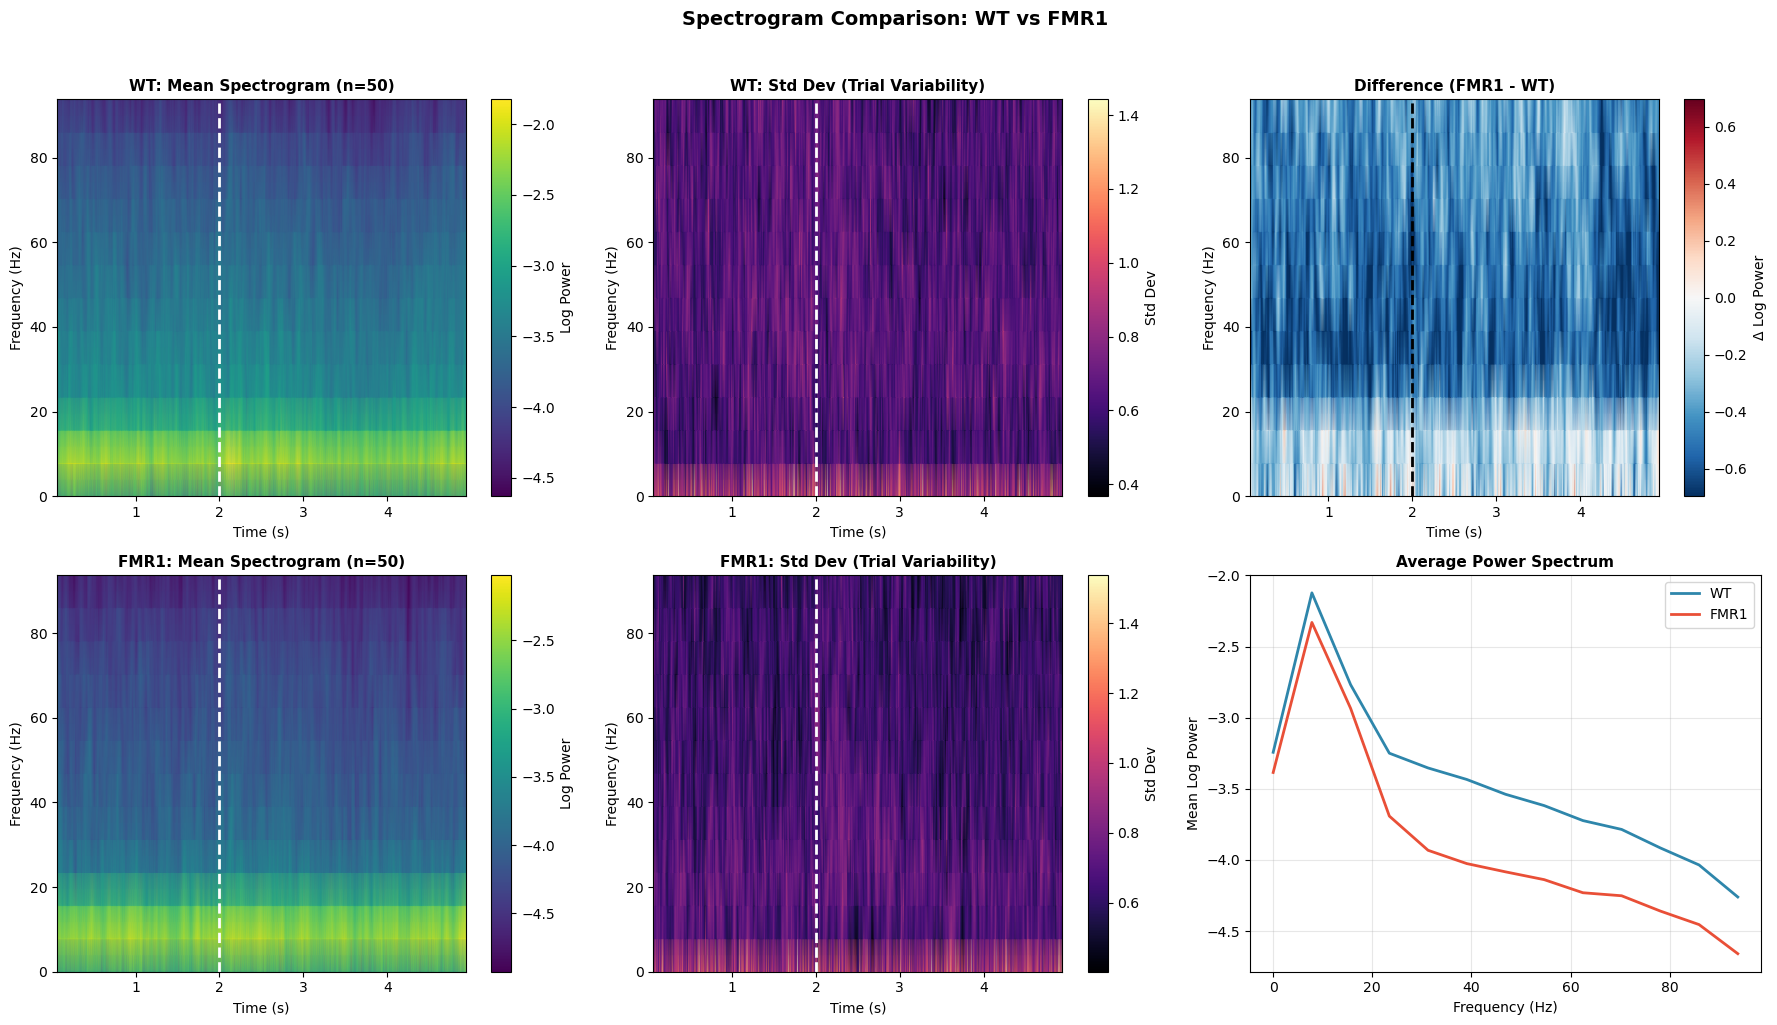

In [ ]:
# WT vs FMR1 Average Spectrogram Comparison
N_SAMPLES = 50  # Number of trials to average per condition

# Spectrogram parameters (using balanced settings)
SPEC_NPERSEG = 128
SPEC_NOVERLAP = 120

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

mean_specs = {}
for row_idx, condition in enumerate(['WT', 'FMR1']):
    condition_df = sample_data[sample_data['condition'] == condition]
    
    # Sample trials
    sample_df = condition_df.sample(n=min(N_SAMPLES, len(condition_df)), random_state=42)
    
    # Compute spectrograms for all sampled trials
    specs = []
    for _, trial_row in sample_df.iterrows():
        trial_trace = parse_trace(trial_row['trace'])
        spec, freqs, times = compute_spectrogram(
            trial_trace, nperseg=SPEC_NPERSEG, noverlap=SPEC_NOVERLAP, 
            log_scale=True, normalize=False
        )
        specs.append(spec)
    
    specs = np.array(specs)
    mean_spec = specs.mean(axis=0)
    std_spec = specs.std(axis=0)
    mean_specs[condition] = mean_spec
    
    # Plot mean spectrogram
    ax_mean = axes[row_idx, 0]
    im = ax_mean.pcolormesh(times, freqs, mean_spec, shading='gouraud', cmap='viridis')
    ax_mean.axvline(STIMULUS_ONSET, color='white', linestyle='--', linewidth=2)
    ax_mean.set_xlabel('Time (s)', fontsize=10)
    ax_mean.set_ylabel('Frequency (Hz)', fontsize=10)
    ax_mean.set_title(f'{condition}: Mean Spectrogram (n={len(specs)})', fontsize=11, fontweight='bold')
    plt.colorbar(im, ax=ax_mean, label='Log Power')
    
    # Plot std spectrogram (variability)
    ax_std = axes[row_idx, 1]
    im_std = ax_std.pcolormesh(times, freqs, std_spec, shading='gouraud', cmap='magma')
    ax_std.axvline(STIMULUS_ONSET, color='white', linestyle='--', linewidth=2)
    ax_std.set_xlabel('Time (s)', fontsize=10)
    ax_std.set_ylabel('Frequency (Hz)', fontsize=10)
    ax_std.set_title(f'{condition}: Std Dev (Trial Variability)', fontsize=11, fontweight='bold')
    plt.colorbar(im_std, ax=ax_std, label='Std Dev')

# Plot difference (FMR1 - WT)
diff_spec = mean_specs['FMR1'] - mean_specs['WT']
ax_diff = axes[0, 2]
vmax = np.percentile(np.abs(diff_spec), 95)
im_diff = ax_diff.pcolormesh(times, freqs, diff_spec, shading='gouraud', cmap='RdBu_r', 
                              vmin=-vmax, vmax=vmax)
ax_diff.axvline(STIMULUS_ONSET, color='black', linestyle='--', linewidth=2)
ax_diff.set_xlabel('Time (s)', fontsize=10)
ax_diff.set_ylabel('Frequency (Hz)', fontsize=10)
ax_diff.set_title('Difference (FMR1 - WT)', fontsize=11, fontweight='bold')
plt.colorbar(im_diff, ax=ax_diff, label='Δ Log Power')

# Plot power spectrum comparison (averaged over time)
ax_power = axes[1, 2]
for condition, color in [('WT', '#2E86AB'), ('FMR1', '#E94F37')]:
    mean_power = mean_specs[condition].mean(axis=1)  # Average over time
    ax_power.plot(freqs, mean_power, linewidth=2, color=color, label=condition)

ax_power.set_xlabel('Frequency (Hz)', fontsize=10)
ax_power.set_ylabel('Mean Log Power', fontsize=10)
ax_power.set_title('Average Power Spectrum', fontsize=11, fontweight='bold')
ax_power.legend()
ax_power.grid(True, alpha=0.3)

plt.suptitle('Spectrogram Comparison: WT vs FMR1', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 3D ViT Input Preview
Visualize what a sequence of trial spectrograms looks like - this is the actual input format for the model.


3D Input Tensor Shape: (8, 13, 610)
  - n_trials: 8
  - freq_bins: 13
  - time_bins: 610


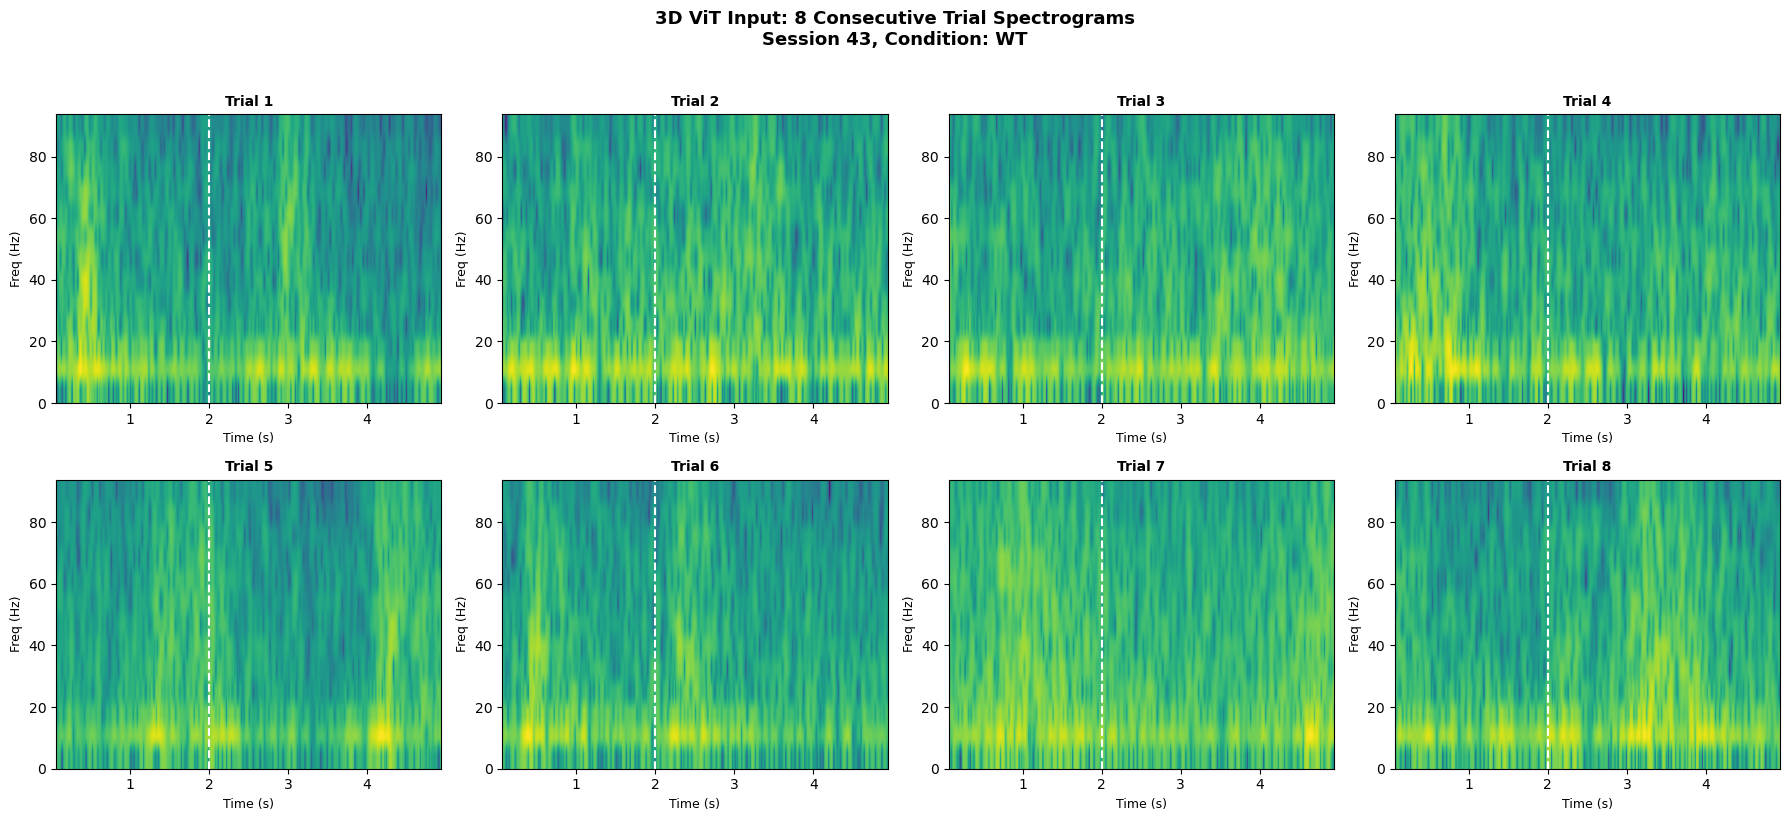


✅ This tensor shape (8, 13, 610) is ready for the 3D ViT model!


In [ ]:
# 3D ViT Input Preview: Sequence of trial spectrograms
N_TRIALS_SEQUENCE = 8  # Number of consecutive trials (model input)

# Get consecutive trials from one session
session_id = sample_data['session'].iloc[0]
session_df = sample_data[sample_data['session'] == session_id].head(N_TRIALS_SEQUENCE)

# Build 3D tensor
trial_specs = []
for _, trial_row in session_df.iterrows():
    trial_trace = parse_trace(trial_row['trace'])
    spec, freqs, times = compute_spectrogram(
        trial_trace, nperseg=SPEC_NPERSEG, noverlap=SPEC_NOVERLAP,
        log_scale=True, normalize=True  # Normalize for model input
    )
    trial_specs.append(spec)

trial_tensor = np.stack(trial_specs)  # Shape: (n_trials, freq_bins, time_bins)

print(f"3D Input Tensor Shape: {trial_tensor.shape}")
print(f"  - n_trials: {trial_tensor.shape[0]}")
print(f"  - freq_bins: {trial_tensor.shape[1]}")
print(f"  - time_bins: {trial_tensor.shape[2]}")

# Visualize the sequence
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    im = ax.imshow(trial_specs[i], aspect='auto', origin='lower', cmap='viridis',
                   extent=[times[0], times[-1], freqs[0], freqs[-1]])
    ax.axvline(STIMULUS_ONSET, color='white', linestyle='--', linewidth=1.5)
    ax.set_xlabel('Time (s)', fontsize=9)
    ax.set_ylabel('Freq (Hz)', fontsize=9)
    ax.set_title(f'Trial {i+1}', fontsize=10, fontweight='bold')

plt.suptitle(f'3D ViT Input: {N_TRIALS_SEQUENCE} Consecutive Trial Spectrograms\n'
             f'Session {session_id}, Condition: {session_df.iloc[0]["condition"]}',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\n✅ This tensor shape {trial_tensor.shape} is ready for the 3D ViT model!")


In [ ]:
# Class balance in sample dataset
class_counts = sample_data['condition'].value_counts(dropna=False)
class_pct = (class_counts / class_counts.sum() * 100).round(2)
class_balance = class_counts.to_frame(name='count')
class_balance['pct'] = class_pct
display(class_balance)
